In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.cm as cm
%matplotlib inline
import cmocean
import plotting
from takeout import monthly_means_annual

import copy

In [2]:
# constant declarations
#lat1 < lat2
lat1 = -20
lat2 = 20

lat_lims = [lat1,lat2]


#variable files on disk
omega_file = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/w/w.nc'
omega_file_full = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/mergeFiles/w_7917.nc'


lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]

#lon_list_labels = ["180W", "150W", "120W", "90W", "60W", "30W", "0", "30E", "60E", "90E", "120E", "150E", "180E"]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

#ytick_list = [36, 25, 21, 17, 14, 10, 9]
p_tick_list = [0, 1, 5, 8, 12, 16, 28]
p_list = [70, 100, 200, 300, 500, 700, 1000]
z_list = [5, 10, 15, 20, 25]

#for plotting
vmin = -0.5
vmax = 0.55
contours = np.arange(vmin, vmax, 0.05)

colormap = cmocean.cm.balance
colorbar_label = r"$Pa \hspace{1} s^{-1}$"

left_title_diff = '[$-\omega + \omega$]'

#It is actually omega, but weighted for regions where it is upward(or negative) between x˚S and x˚N.
right_title_diff = '1989-2007'
right_title_diff_full = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

figure_name_diff = 'lon_omegaDifference_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'area_weight_avg.pdf'
figure_name_diff_full = 'lon_omegaDifference_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'area_weight_avg_AllYears.pdf'

# Data Import

In [3]:
#read in data files
#omega is in hPa NOT Pa
omega_data = nc.Dataset(omega_file_full)

#process variables
omega = omega_data.variables['w'][:]

lon  = omega_data.variables['longitude'][:]
lat  = omega_data.variables['latitude'][:]
dumb_time = omega_data.variables['time'][:]
#shortened file: levelist, full file: level
p = omega_data.variables['level'][:]

#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = p >= 70

#subset new tensors for correct latitude, pressure ranges
omega_lat = omega[:, :, latidx, :]
omega_lat_p = omega_lat[:, pidx, :, :]

In [4]:
#create monthly means for normalization
monthly_means = monthly_means_annual(omega_lat_p, time)
print(np.shape(monthly_means))
print(np.shape(omega_lat_p))

(12, 28, 27, 240)
(468, 28, 27, 240)


In [5]:
#normalize omega data, subtract monthly means
count = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count-1].month - 1
        #print(i, j, time[count-1].month, month)
        omega_lat_p[count-1] = omega_lat_p[count-1] - monthly_means[month]
        count = count + 1

### Start Mask Here

### For difference plot, need to:
- up: replace negative values w/ 1, change all positive omegas to NaN: $M^{up}$
- down: replace negative values w/ NaN, change all positive omegas to 1: $M^{down}$
- multiply by cos(lat) matrix to weight omega properly: $M^n*cos\phi$
- nan mean over lat (along lon dimension)
- integrate (average) over time dimension
- divide by total area: $\Sigma A^{total}$
- Weighted average $= \frac{\Sigma A^{up}X + \Sigma A^{down}X}{\Sigma A^{total}}$

In [6]:
#copy array for creating mask
mask_up = copy.deepcopy(omega_lat_p)
mask_down = copy.deepcopy(omega_lat_p)
mask_total = copy.deepcopy(omega_lat_p)

#upward mask: M_up
mask_up[np.where(mask_up > 0)] = np.nan
mask_up[np.where(mask_up < 0)] = 1

#downward mask: M_down
mask_down[np.where(mask_down > 0)] = 1
mask_down[np.where(mask_down < 0)] = np.nan

#total mask for A_total
mask_total.fill(1)

#MX
mask_var_up = np.multiply(omega_lat_p, mask_up)
mask_var_down = np.multiply(omega_lat_p, mask_down)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [7]:
#create cos(lat) matrix
cos_lat_ = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((27,240)), cos_lat_)

#MXcos(lat) = AX
mask_var_coslat_up = np.multiply(mask_var_up, cos_lat_matrix)
mask_var_coslat_down = np.multiply(mask_var_down, cos_lat_matrix)

#A_total
mask_total_coslat = np.multiply(mask_total, cos_lat_matrix)

In [8]:
##from scipy import ndimage
#fig, ax = plt.subplots(1, 2, figsize=(14, 7))
#ax[0].pcolormesh(mask_total_coslat[0,27])
#ax[1].plot(cos_lat, np.arange(len(cos_lat)))
#plt.savefig('lat_lon_weighting', format='pdf')

In [9]:
#nan mean over lat (along lon dimension)
mask_var_nanmean_up = np.nanmean(mask_var_coslat_up, axis=2)
mask_var_nanmean_down = np.nanmean(mask_var_coslat_down, axis=2)

mask_total_mean = np.mean(mask_total_coslat, axis=2)

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#integrate, or sum over time dimension
#NEED TO NAN SUM, ΣMXcos(lat) = ΣAX
sum_mask_var_up = np.nanmean(mask_var_nanmean_up, axis=0)
sum_mask_var_down = np.nanmean(mask_var_nanmean_down, axis=0)

#ΣA_total
sum_mask_total = np.nanmean(mask_total_mean, axis=0)

#(ΣAX_up + ΣAX_down)/ ΣA_total
difference = (sum_mask_var_up * 100 + sum_mask_var_down * 100) / sum_mask_total

In [11]:
#shift array to have Tropics in the middle
zeros = np.zeros((28, 240))
zeros[:, 0:120] = difference[:, 60:180]
zeros[:, 120:180] = difference[:, 180:240]
zeros[:, 180:240] = difference[:, 0:60]

print(np.shape(zeros))

(28, 240)


In [12]:
print(np.max(zeros))
print(np.min(zeros))

0.038020905184922876
-0.5023811388510431


# $\omega$ Map

<Figure size 21600x5400 with 0 Axes>

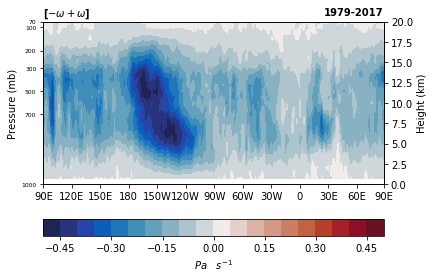

In [14]:
plotting.plot_contours_latHeight(vmin, vmax, zeros, contours, colormap, colorbar_label, left_title_diff, right_title_diff_full, 
                                 p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_diff_full, False)